# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np

In [ ]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 26346183.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


horse


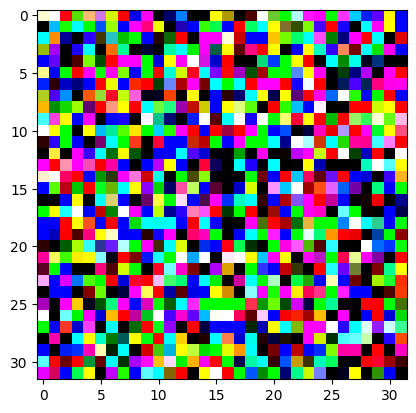

In [ ]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    print(classes[y[0]])
    break


In [37]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
epochs = 100
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        yp = model(x)
        l = loss(yp, y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))


0 1.4856804347768122
1 1.4162908981041031
2 1.399163736372578
3 1.3827153091527977
4 1.3690394972051894
5 1.356213995388576
6 1.3459324119042377
7 1.3360013669850874
8 1.3247352802023595
9 1.313817203653102
10 1.3054219502575544
11 1.2951232803111175
12 1.28770443310543
13 1.2793505380348282
14 1.2693697974389913
15 1.2605178337924334
16 1.2557398159893192
17 1.2460548403311749
18 1.2403668305095361
19 1.2323459769998277
20 1.2264526060649328
21 1.219118399887669
22 1.2143580797983675
23 1.2060478366151148
24 1.2004805815463164
25 1.1951384483551493
26 1.1892759650945663
27 1.182484936349246
28 1.1773692582334792
29 1.172113615031145
30 1.1689744576507686
31 1.1642275099851647
32 1.157882358650772
33 1.151326490908253
34 1.1491870612514263
35 1.143079671324516
36 1.1410990418220053
37 1.1366983034781046
38 1.1301512176893196
39 1.1272249516783928
40 1.122640969497817
41 1.1202455202535706
42 1.1135439720689033
43 1.109924585843573
44 1.106189529810633
45 1.103345933921483
46 1.09927427

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Lab_04_OOD/cifar10_CNN_100.pth')

In [7]:
model = CNN().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Lab_04_OOD/cifar10_CNN_100.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
#here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 0.6098999977111816


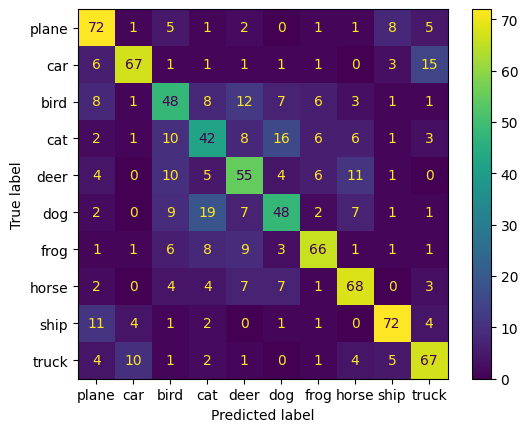

In [ ]:
#Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')
from sklearn import metrics

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=classes)
disp.plot()
plt.show()


tensor(7)


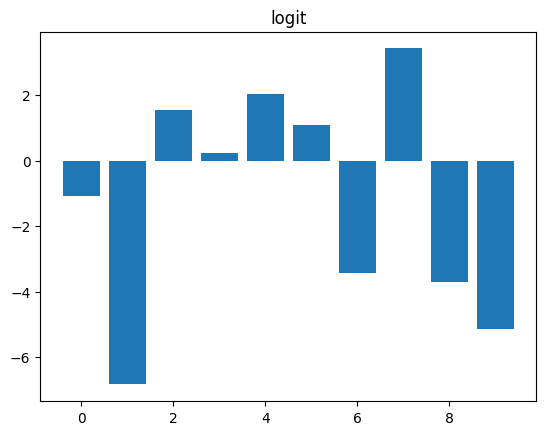

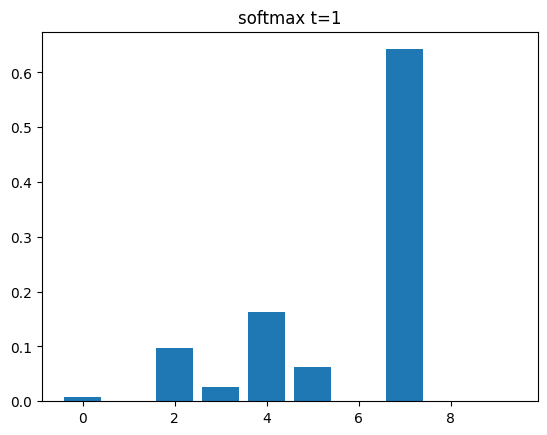

In [ ]:
#Example of logit and softmax output
print(y[0])
output = model(x)
plt.bar(np.arange(10),output[0].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[0].detach().cpu())
plt.show()




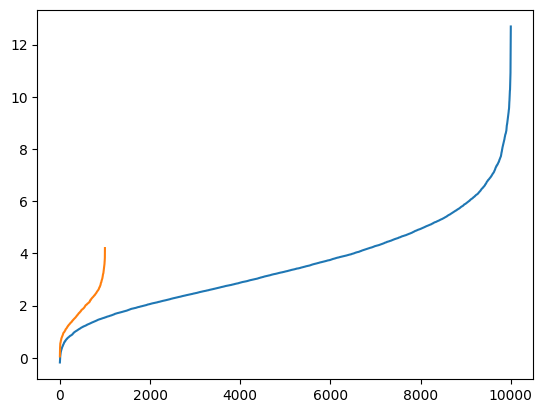

In [8]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=10000
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)


plt.plot(sorted(scores_test.cpu()))
plt.plot(sorted(scores_fake.cpu()))


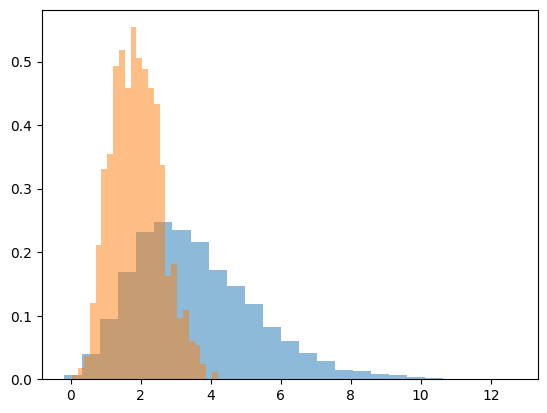

In [ ]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25)
plt.show()


In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [ ]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 1.1865450216799367
1 0.8762195259332657
2 0.8014837199327897
3 0.7683343647085891
4 0.7508895813810582
5 0.7412123813921091
6 0.7346082077342637
7 0.7279894507052947
8 0.721578484895278
9 0.7129410824605397
10 0.7062738811483189
11 0.702393830430751
12 0.6995578073725408
13 0.6968573742375082
14 0.6949542879450078
15 0.6929066460959765
16 0.690722893695442
17 0.6888675945145744
18 0.6872550756955633
19 0.6855497874167501


In [ ]:
torch.save(model_ae.state_dict(), '/content/drive/MyDrive/Lab_04_OOD/cifar10_model_ae_20.pth')

In [10]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model_ae = Autoencoder().to(device)

model_ae.load_state_dict(torch.load('/content/drive/MyDrive/Lab_04_OOD/cifar10_model_ae_20.pth', map_location=torch.device('cpu'))) #20 epochs


<All keys matched successfully>

In [11]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)

scores_fake_ae = torch.cat(scores_fake_ae)



scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)

scores_test_ae = torch.cat(scores_test_ae)



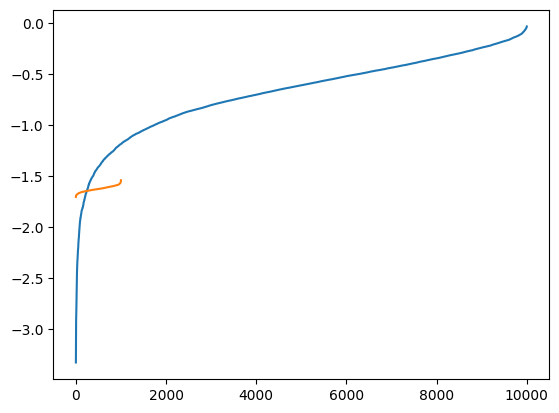

In [ ]:
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))


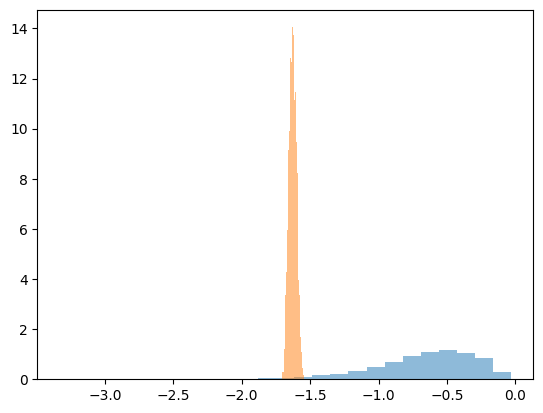

In [ ]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



In [14]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=10000
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)


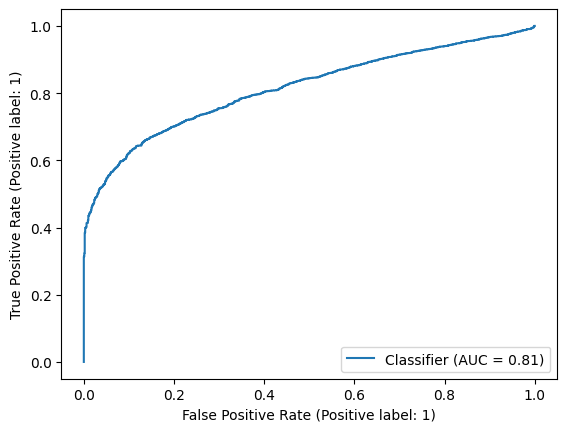

In [15]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

In [9]:
from sklearn import metrics

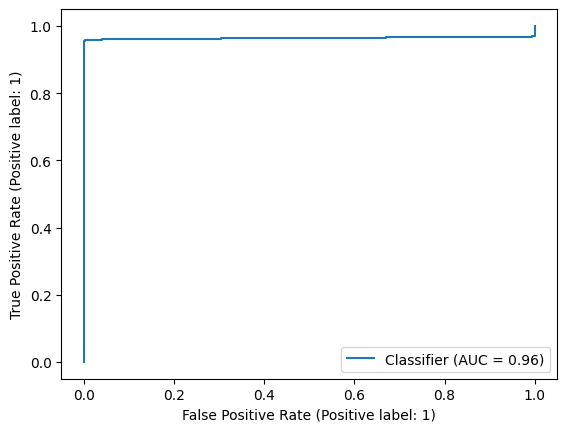

In [13]:
#AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

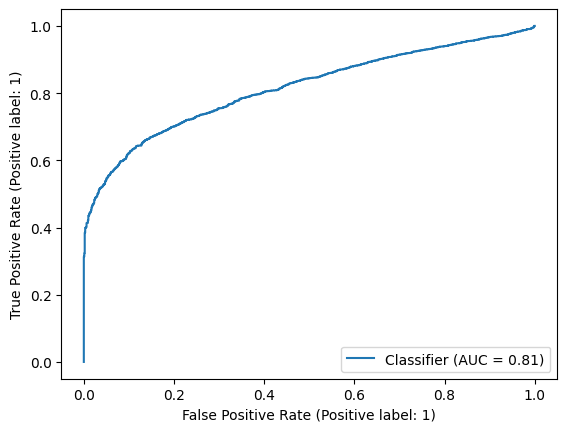

In [ ]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

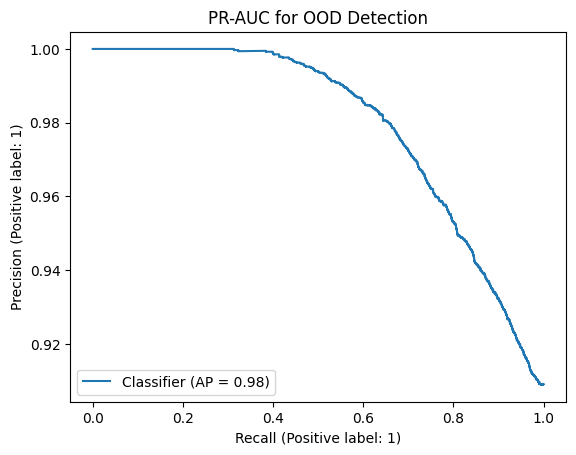

In [ ]:
def plot_pr_auc_ood(scores_test, scores_ood):
    y_test = torch.ones_like(scores_test)
    y_ood = torch.zeros_like(scores_ood)
    y = torch.cat((y_test, y_ood))
    y_pred = torch.cat((scores_test, scores_ood))

    metrics.PrecisionRecallDisplay.from_predictions(y.cpu(), y_pred.cpu())
    plt.title("PR-AUC for OOD Detection")
    plt.show()

plot_pr_auc_ood(scores_test, scores_fake)


the autoencoder's latent space is well-structured and the decoder can accurately reconstruct ID data, the model has a clear distinction between ID and OOD data based on how well it reconstructs the inputs

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [ ]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


7 7


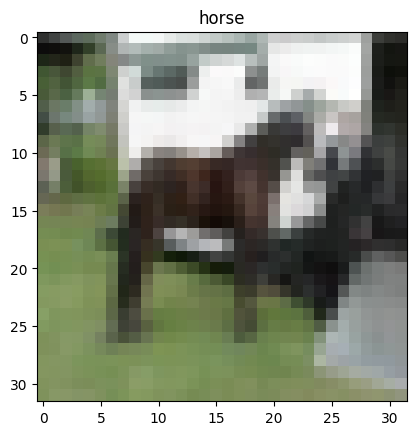

Attack!!
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
9 7
Success!


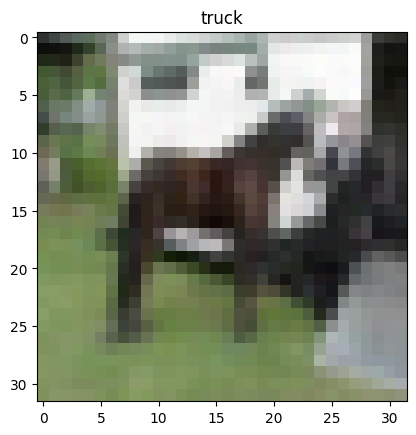

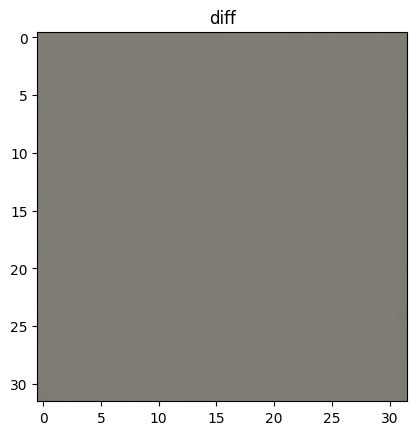

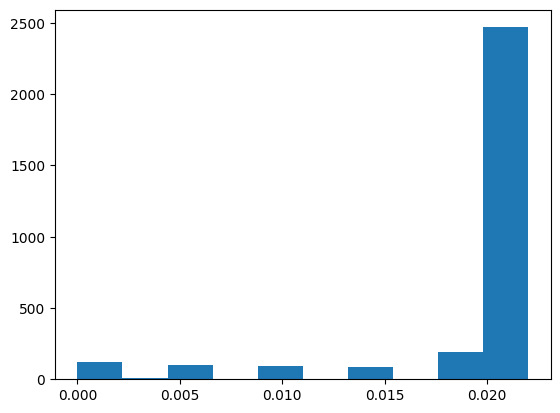

In [ ]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break

sample_id = 20
x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True
#print(x)

before = x.clone()
output=model(x)
eps = 0.002
print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item():
    print('classifier is already wrong!')
else:
    print('Attack!!')

    #only attack if y==model(x)
    while output.argmax() == y: #attack until success!

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        l = loss(output,y)
        l.backward()



        x = x + eps*torch.sign(x.grad)#fgsm

        print(output.argmax().item(),  y.item())
        if output.argmax().item()!=  y.item():
            print('Success!')



    img = inv(x[0])
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(classes[output.argmax()])
    plt.show()

    diff = torch.abs(x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())






In [20]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))


In [21]:
def generate_adversarial_example(model, x, y, eps=0.002):
    model.eval()
    x = x[None, :].to(device)
    y = y[None].to(device)
    x.requires_grad = True

    before = x.clone()
    output = model(x)
    if output.argmax().item() != y.item():
        print('Classifier is already wrong!')
        return None, None
    else:
        print('Attack!!')

        while output.argmax() == y:  # Attack until success!
            x.retain_grad()
            output = model(x)
            model.zero_grad()
            l = nn.CrossEntropyLoss()(output, y)
            l.backward()

            x = x + eps * torch.sign(x.grad)  # FGSM

            if output.argmax().item() != y.item():
                print('Success!')
                break

        return x.detach(), before.detach()



In [29]:
# Example usage
for data in testloader:
    x, y = data
    break

sample_id = 20
x_sample, y_sample = x[sample_id], y[sample_id]

adv_x, orig_x = generate_adversarial_example(model, x_sample, y_sample, eps=0.002)


Attack!!
Success!


In [23]:
def visualize_adversarial_example(orig_x, adv_x, inv, classes, output):
    if orig_x is not None and adv_x is not None:
        img = inv(adv_x[0])
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.title(classes[output.argmax()])
        plt.show()

        diff = torch.abs(adv_x - orig_x)
        diff_img = inv(diff[0])
        plt.imshow(diff_img.permute(1, 2, 0).cpu().numpy())
        plt.title('Difference')
        plt.show()

        diff_flat = diff.flatten()
        plt.hist(diff_flat.cpu().numpy(), bins=100)
        plt.title('Histogram of differences')
        plt.show()



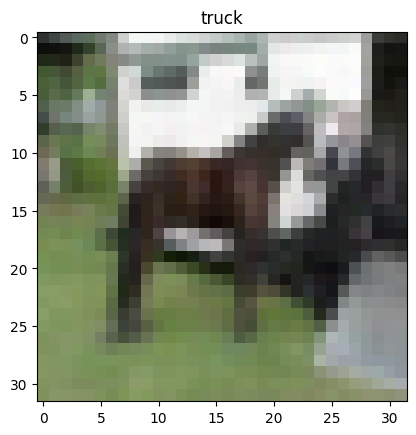

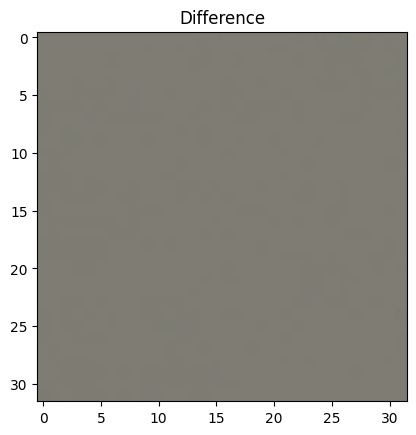

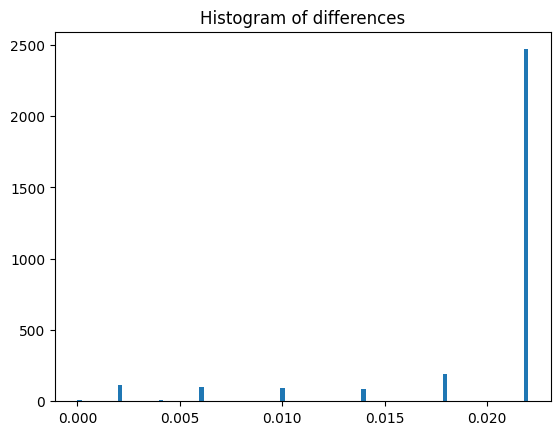

In [30]:
# Example usage
if adv_x is not None and orig_x is not None:
    output = model(adv_x)
    visualize_adversarial_example(orig_x, adv_x, inv, classes, output)

Evaluating for epsilon = 0.001
Attack!!
Success!


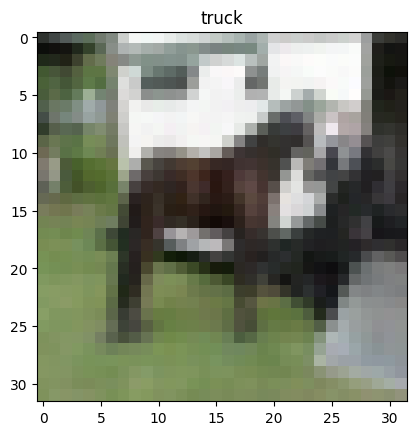

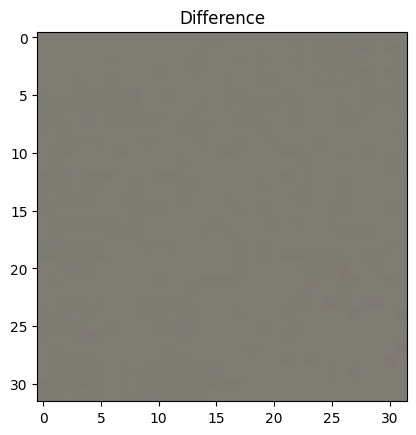

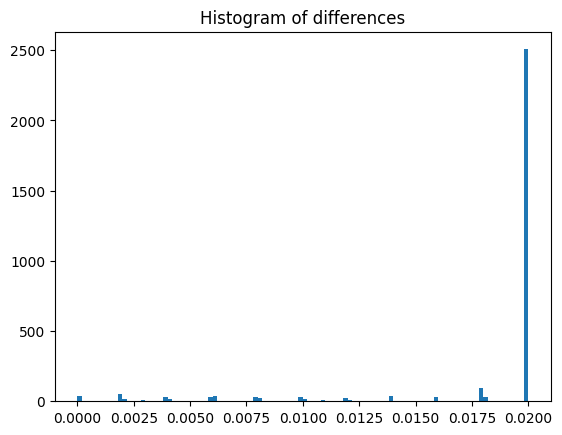

Evaluating for epsilon = 0.002
Attack!!
Success!


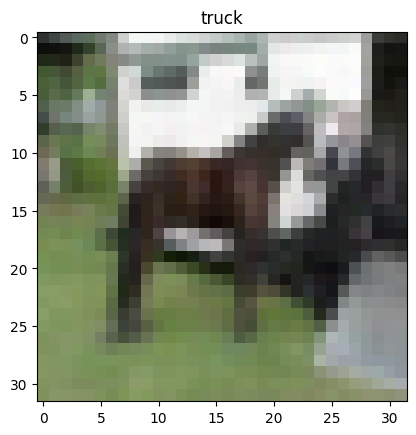

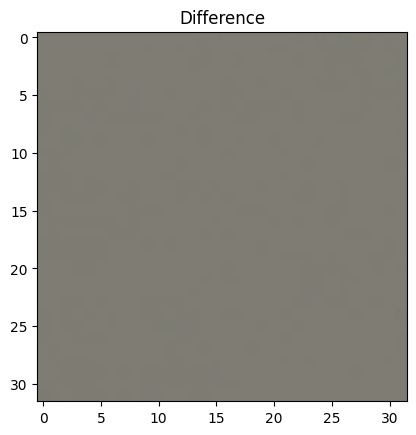

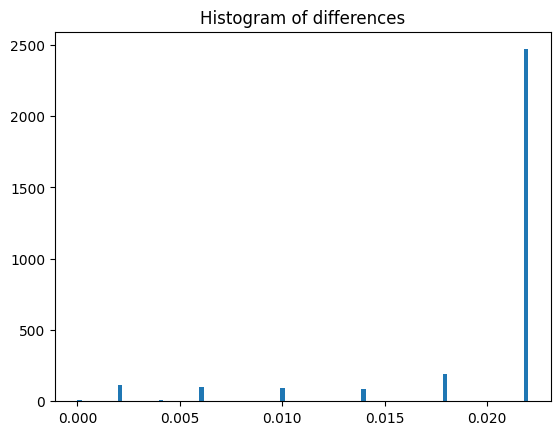

Evaluating for epsilon = 0.005
Attack!!
Success!


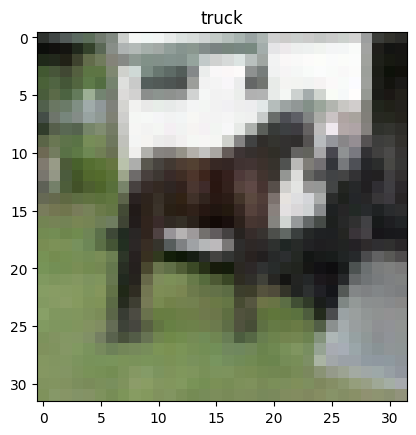

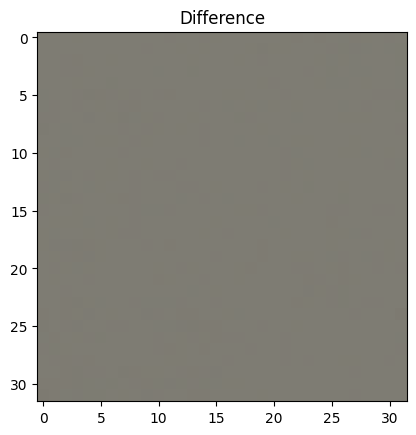

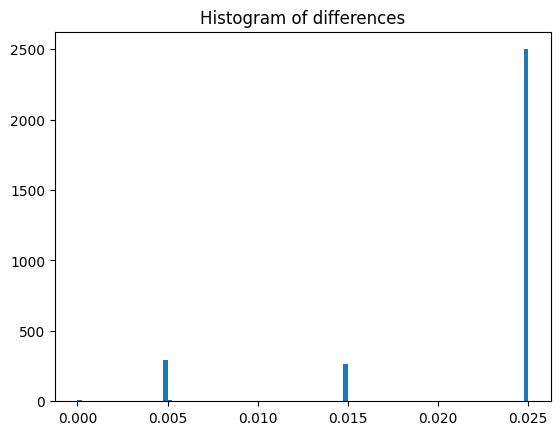

Evaluating for epsilon = 0.01
Attack!!
Success!


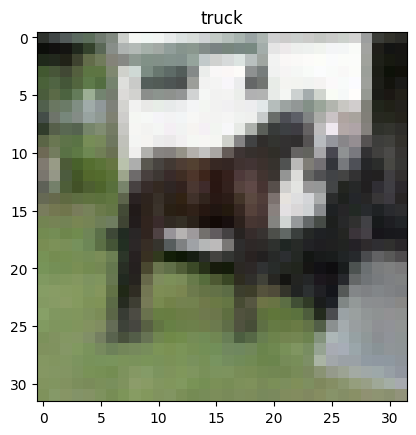

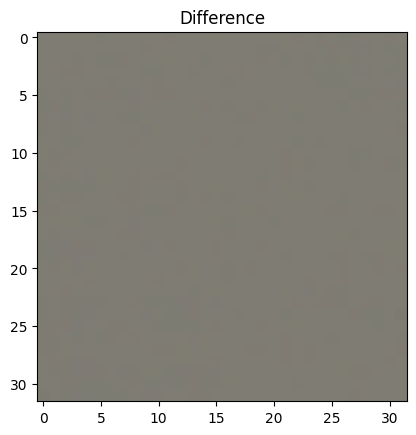

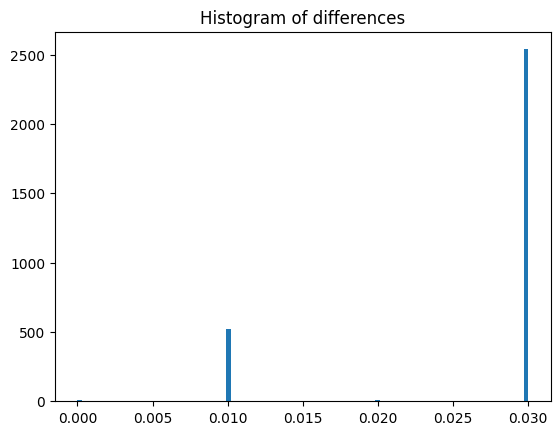

Evaluating for epsilon = 0.02
Attack!!
Success!


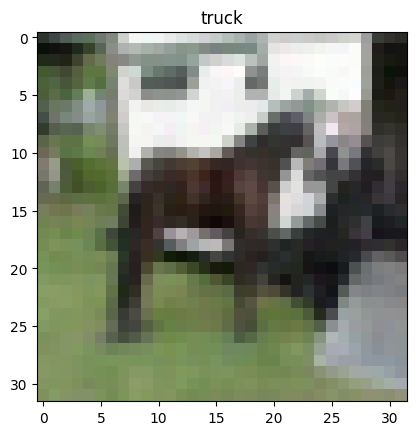

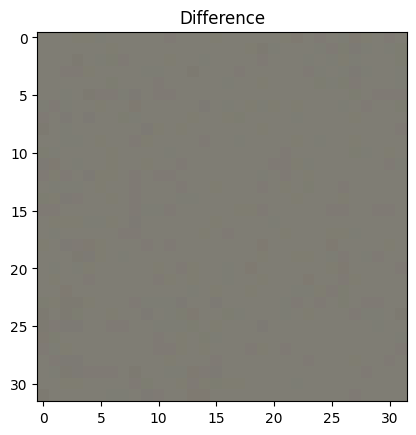

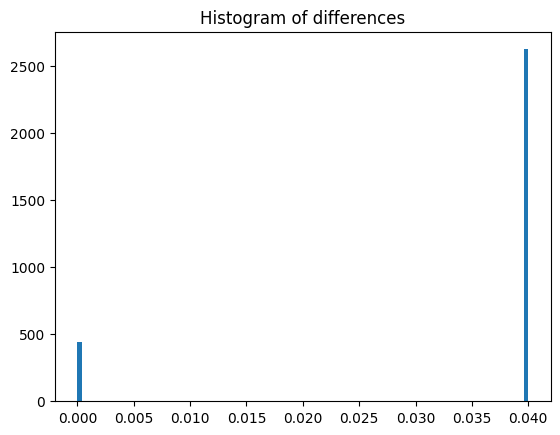

In [31]:
epsilons = [0.001, 0.002, 0.005, 0.01, 0.02]

for eps in epsilons:
    print(f'Evaluating for epsilon = {eps}')
    adv_x, orig_x = generate_adversarial_example(model, x_sample, y_sample, eps)
    if adv_x is not None and orig_x is not None:
        output = model(adv_x)
        visualize_adversarial_example(orig_x, adv_x, inv, classes, output)


In [32]:
def evaluate_adversarial_examples(testloader, model, epsilons):
    success_rates = {}
    for eps in epsilons:
        success = 0
        total = 0
        for data in testloader:
            x, y = data
            for i in range(len(x)):
                adv_x, orig_x = generate_adversarial_example(model, x[i], y[i], eps)
                if adv_x is not None:
                    output = model(adv_x)
                    if output.argmax().item() != y[i].item():
                        success += 1
                    total += 1
        success_rates[eps] = success / total if total > 0 else 0
    return success_rates



In [36]:
def generate_adversarial_example_simple(model, x, y, eps=0.002):
    x = x[None, :].to(device)
    y = y[None].to(device)
    x.requires_grad = True

    output = model(x)
    model.zero_grad()
    l = nn.CrossEntropyLoss()(output, y)
    l.backward()

    # Apply the perturbation
    adv_x = x + eps * torch.sign(x.grad)

    return adv_x.detach(), x.detach()


In [37]:
def evaluate_model_accuracy_simple(model, testloader, epsilons):
    accuracy_results = []
    for eps in epsilons:
        correct = 0
        total = 0
        for data in testloader:
            x, y = data
            for i in range(len(x)):
                adv_x, _ = generate_adversarial_example_simple(model, x[i], y[i], eps)
                output = model(adv_x)
                if output.argmax().item() == y[i].item():
                    correct += 1
                total += 1
        accuracy = correct / total if total > 0 else 0
        accuracy_results.append(accuracy)
        print(f'Epsilon: {eps}, Accuracy: {accuracy:.4f}')
    return accuracy_results



Epsilon: 0.0, Accuracy: 0.6099
Epsilon: 0.001, Accuracy: 0.6004
Epsilon: 0.002, Accuracy: 0.5884
Epsilon: 0.005, Accuracy: 0.5567
Epsilon: 0.01, Accuracy: 0.5045
Epsilon: 0.02, Accuracy: 0.4055


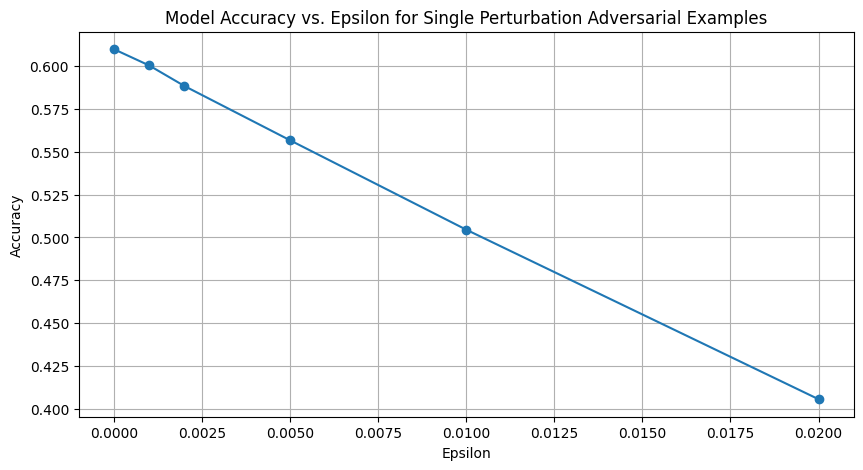

In [38]:
# Example usage
epsilons = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02]
accuracy_results = evaluate_model_accuracy_simple(model, testloader, epsilons)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracy_results, marker='o')
plt.title('Model Accuracy vs. Epsilon for Single Perturbation Adversarial Examples')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [49]:
# Function to visualize adversarial examples and perturbations
def visualize_adversarial_examples(model, data, epsilons):
    x, y = data
    x, y = x.to(device), y.to(device)

    fig, axs = plt.subplots(len(epsilons), 3, figsize=(15, 5 * len(epsilons)))

    for i, eps in enumerate(epsilons):
        adv_x, orig_x = generate_adversarial_example_simple(model, x, y, eps)

        # Convert tensors to images
        inv = NormalizeInverse((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
        orig_img = inv(orig_x[0]).permute(1, 2, 0).cpu().numpy()
        adv_img = inv(adv_x[0]).permute(1, 2, 0).cpu().numpy()
        perturbation = (adv_img - orig_img).clip(0, 1)

        # diff = torch.abs(adv_x - orig_x)
        # diff_img = inv(diff[0])
        # plt.imshow(diff_img.permute(1, 2, 0).cpu().numpy())

        # Plot original image
        axs[i, 0].imshow(orig_img)
        axs[i, 0].set_title(f'Original Image\nClass: {classes[y.item()]}')
        axs[i, 0].axis('off')

        # Plot adversarial image
        axs[i, 1].imshow(adv_img)
        pred_class = classes[model(adv_x).argmax().item()]
        axs[i, 1].set_title(f'Adversarial Image (eps={eps})\nPred: {pred_class}')
        axs[i, 1].axis('off')

        # Plot perturbation
        axs[i, 2].imshow(perturbation)
        axs[i, 2].set_title('Perturbation')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()



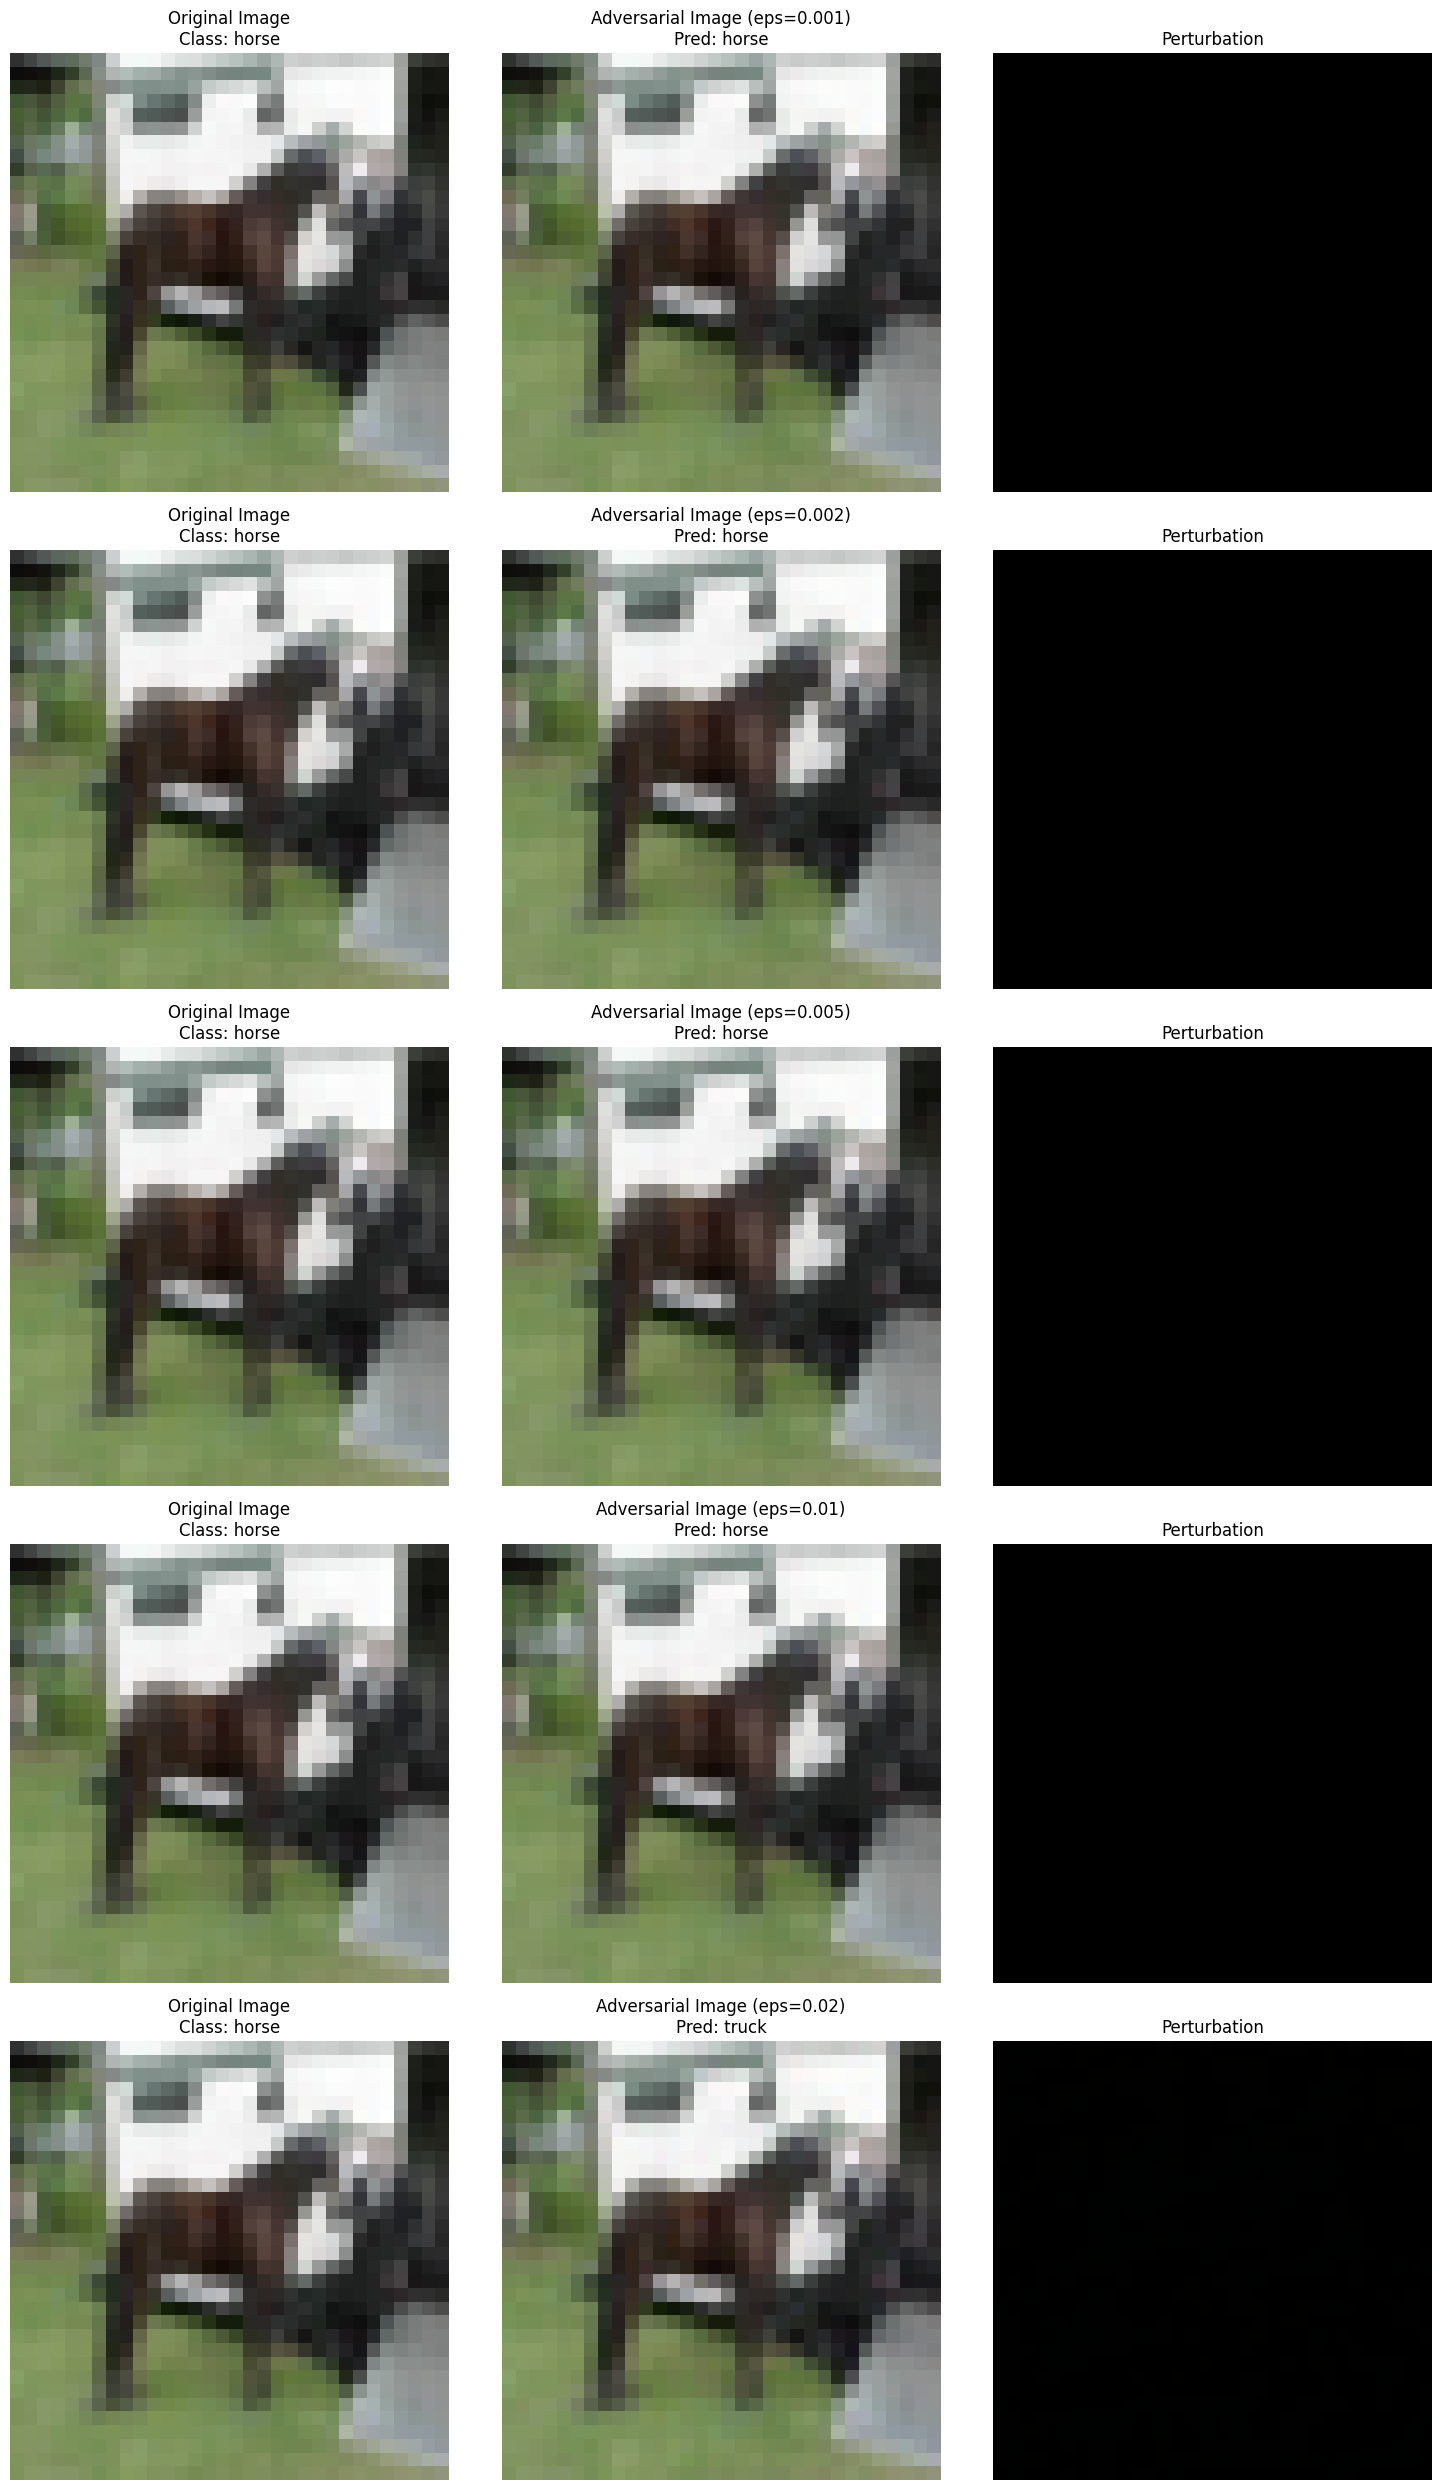

In [50]:
# Example usage
for data in testloader:
    x, y = data
    break

epsilons = [0.001, 0.002, 0.005, 0.01, 0.02]
visualize_adversarial_examples(model, (x[20], y[20]), epsilons)

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
# Your code here.

In [ ]:
import torch
from torch.utils.data import Subset, DataLoader
import random
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [ ]:
print(f'Size of OOD subset: {len(fakeloader.dataset)}')

Size of OOD subset: 1000


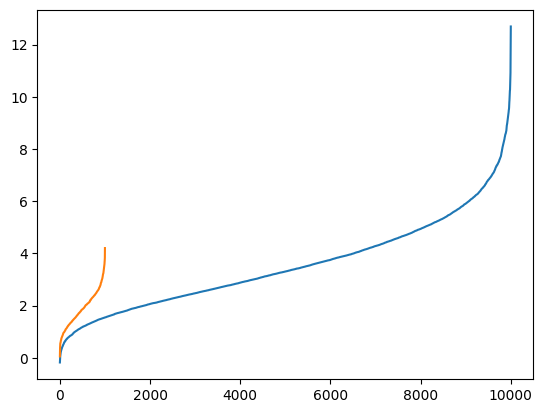

In [68]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=10000
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)


plt.plot(sorted(scores_test.cpu()))
plt.plot(sorted(scores_fake.cpu()))

In [60]:

# Define the FGSM attack function
def fgsm_attack(model, loss_fn, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    loss = loss_fn(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data



# Hyperparameters
learning_rate = 0.001
epochs = 50
epsilon = 0.02  # Perturbation magnitude

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Load the model
model = CNN().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Lab_04_OOD/cifar10_CNN_100.pth', map_location=torch.device('cpu')))
model.train()

for epoch in range(epochs):
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)

        # Standard training step
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)

        # Adversarial training step
        perturbed_data = fgsm_attack(model, loss_fn, data, target, epsilon)
        output_adv = model(perturbed_data)
        loss_adv = loss_fn(output_adv, target)

        # Combine losses
        combined_loss = loss + loss_adv

        # Backpropagation and optimization
        combined_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Adversarial Loss: {loss_adv.item()}, Combined Loss: {combined_loss.item()}")

Epoch 1/10, Loss: 0.8937376141548157, Adversarial Loss: 3.146982431411743, Combined Loss: 4.040719985961914
Epoch 2/10, Loss: 1.2469137907028198, Adversarial Loss: 3.4242146015167236, Combined Loss: 4.671128273010254
Epoch 3/10, Loss: 0.9486625790596008, Adversarial Loss: 3.506972074508667, Combined Loss: 4.455634593963623
Epoch 4/10, Loss: 0.829850971698761, Adversarial Loss: 2.644395351409912, Combined Loss: 3.4742462635040283
Epoch 5/10, Loss: 1.0574281215667725, Adversarial Loss: 2.9490580558776855, Combined Loss: 4.006485939025879
Epoch 6/10, Loss: 0.9987122416496277, Adversarial Loss: 2.926896095275879, Combined Loss: 3.9256083965301514
Epoch 7/10, Loss: 0.9279534220695496, Adversarial Loss: 3.3357787132263184, Combined Loss: 4.263731956481934
Epoch 8/10, Loss: 0.9480009078979492, Adversarial Loss: 2.8787026405334473, Combined Loss: 3.8267035484313965
Epoch 9/10, Loss: 1.0044625997543335, Adversarial Loss: 2.788787364959717, Combined Loss: 3.79325008392334
Epoch 10/10, Loss: 0.93

In [63]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Lab_04_OOD/cifar10_CNN_100_adv.pth')

In [75]:
model = CNN().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Lab_04_OOD/cifar10_CNN_100_adv.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

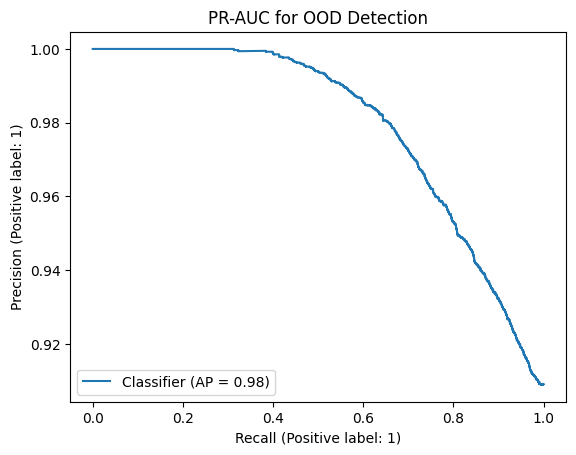

In [59]:
def plot_pr_auc_ood(scores_test, scores_ood):
    y_test = torch.ones_like(scores_test)
    y_ood = torch.zeros_like(scores_ood)
    y = torch.cat((y_test, y_ood))
    y_pred = torch.cat((scores_test, scores_ood))

    metrics.PrecisionRecallDisplay.from_predictions(y.cpu(), y_pred.cpu())
    plt.title("PR-AUC for OOD Detection")
    plt.show()

plot_pr_auc_ood(scores_test, scores_fake)

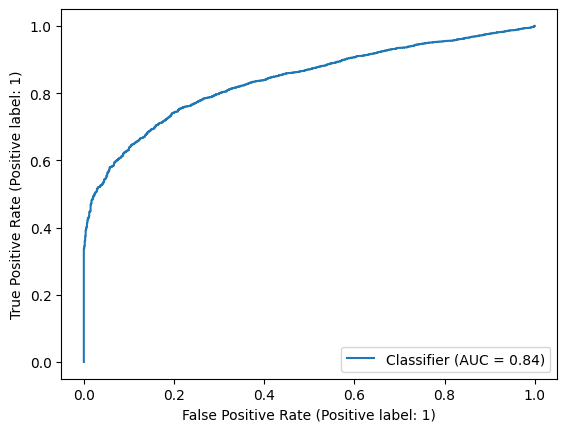

In [ ]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.




In [18]:
from sklearn.metrics import roc_auc_score, average_precision_score
from itertools import product
from sklearn import metrics
import torch
import numpy as np


In [53]:
# Modification of the structure of our CNN to add the temperature parameter

class CNN_ODIN(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        logits = logits / self.temperature
        return logits

    def set_temperature(self, temperature):
        self.temperature = temperature


In [54]:
#ODIN scores

def compute_odin_scores(model, data_loader, epsilon, temperature, device):
    model.eval()
    scores = []
    for data in data_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        # Perform ODIN preprocessing
        perturbed_inputs = odin_preprocess(model, inputs, epsilon, temperature, device)

        # No gradient tracking needed during the forward pass of perturbed inputs
        with torch.no_grad():
            outputs = model(perturbed_inputs) / temperature
            max_softmax_score = F.softmax(outputs, dim=1).max(dim=1)[0]
            scores.append(max_softmax_score)
    return torch.cat(scores)

In [8]:
# ODIN preprocessing function
def odin_preprocess(model, inputs, epsilon, temperature, device):
    inputs.requires_grad = True
    outputs = model(inputs) / temperature
    max_softmax_score = F.softmax(outputs, dim=1).max(dim=1)[0]

    loss = -max_softmax_score.mean()  # Minimize the negative of the max softmax score
    model.zero_grad()
    loss.backward()

    perturbation = epsilon * inputs.grad.sign()
    perturbed_inputs = inputs + perturbation
    perturbed_inputs = torch.clamp(perturbed_inputs, 0, 1)

    return perturbed_inputs


In [9]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [11]:
def grid_search_odin(model, testloader, oodloader, temperatures, epsilons, device):
    best_auc = 0
    best_t = None
    best_eps = None

    for t, eps in product(temperatures, epsilons):
        scores_test = compute_odin_scores(model, testloader, eps, t, device)
        scores_ood = compute_odin_scores(model, oodloader, eps, t, device)

        all_scores = torch.cat((scores_test, scores_ood))
        labels = torch.cat((torch.ones(len(scores_test)), torch.zeros(len(scores_ood))))

        auc_score = roc_auc_score(labels.cpu(), all_scores.cpu())

        if auc_score > best_auc:
            best_auc = auc_score
            best_t = t
            best_eps = eps

    return best_t, best_eps, best_auc


In [12]:
def plot_scores(scores_test, scores_ood):
    plt.hist(scores_test.cpu().numpy(), bins=50, alpha=0.5, label='ID')
    plt.hist(scores_ood.cpu().numpy(), bins=50, alpha=0.5, label='OOD')
    plt.legend(loc='best')
    plt.xlabel('Scores')
    plt.ylabel('Frequency')
    plt.title('Distribution of ODIN Scores')
    plt.show()

In [ ]:

# Parameters for grid search
temperatures = [1, 10, 50, 100, 500, 1000, 5000, 10000]
epsilons = [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_ODIN().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Lab_04_OOD/cifar10_CNN_100.pth', map_location=torch.device('cpu')))

# Perform grid search
best_t, best_eps, best_auc = grid_search_odin(model, testloader, fakeloader, temperatures, epsilons, device)
print(f'Best Temperature: {best_t}, Best Epsilon: {best_eps}, Best AUC: {best_auc}')



Best Temperature: 10000, Best Epsilon: 0.01, Best AUC: 0.91024925


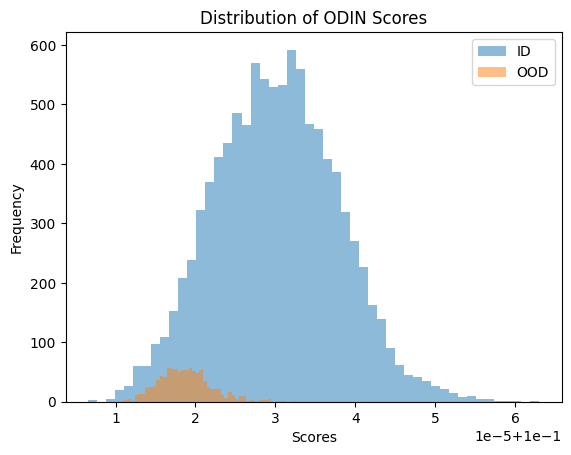

In [44]:
# Plot scores
scores_test = compute_odin_scores(model, testloader, best_eps, best_t, device)
scores_ood = compute_odin_scores(model, fakeloader, best_eps, best_t, device)
plot_scores(scores_test, scores_ood)

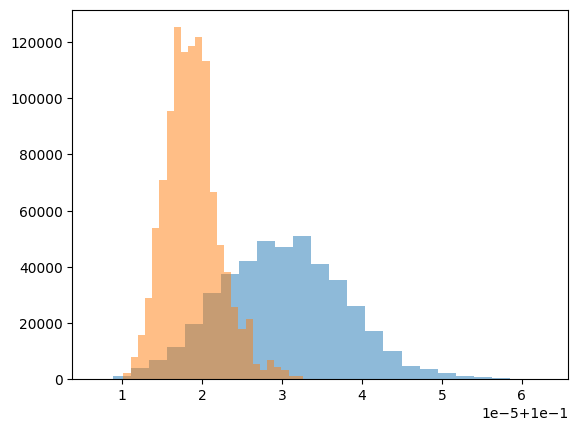

In [35]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_ood.cpu(), density=True, alpha=0.5, bins=25)
plt.show()


We can see here, a clearly the difference with the vanilla model in the exercise 1, we can better distinguish the two distributions

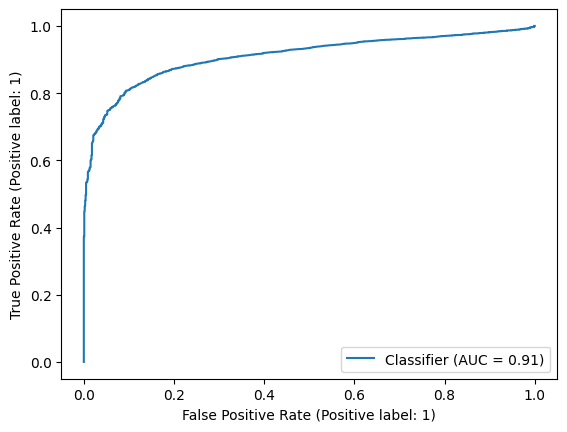

In [24]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_ood))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_ood)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

And here we observe a better AUC, **0.91** ten points greater than the vanilla **0.81** and seven points than the FGSM adversarial training **0.84**

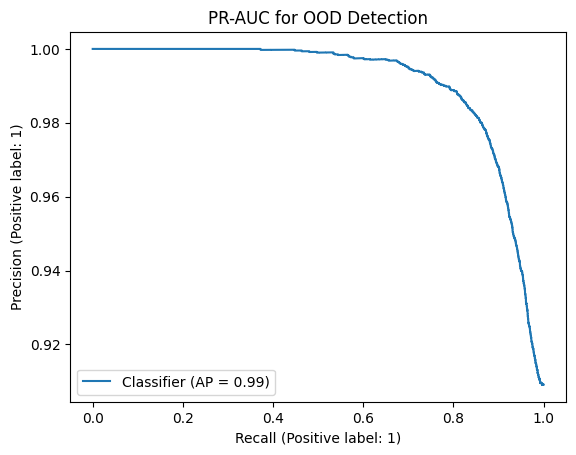

In [46]:
def plot_pr_auc_ood(scores_test, scores_ood):
    y_test = torch.ones_like(scores_test)
    y_ood = torch.zeros_like(scores_ood)
    y = torch.cat((y_test, y_ood))
    y_pred = torch.cat((scores_test, scores_ood))

    metrics.PrecisionRecallDisplay.from_predictions(y.cpu(), y_pred.cpu())
    plt.title("PR-AUC for OOD Detection")
    plt.show()

plot_pr_auc_ood(scores_test, scores_ood)



---

### Summary of OOD Detection Comparison

#### Model Performance Metrics:

- **Without ODIN:**
  - **AUC (Area Under the ROC Curve):** 0.81
  - **AP (Average Precision):** 0.98

- **With ODIN:**
  - **AUC (Area Under the ROC Curve):** 0.91
  - **AP (Average Precision):** 0.99

#### ODIN Optimization Results:

- **Best Temperature:** 10,000
- **Best Epsilon:** 0.01
- **Best AUC with ODIN:** 0.91024925

#### Key Findings:

1. **Improvement with ODIN:**
   - ODIN significantly enhances the model's ability to detect out-of-distribution samples, as indicated by the increase in AUC from 0.81 to 0.91 and a slight improvement in AP from 0.98 to 0.99.

2. **Effectiveness of Parameters:**
   - The grid search results indicate that a high temperature of 10,000 and a small epsilon of 0.01 are optimal for achieving the best performance with ODIN. These parameters help in tuning the softmax output and perturbation to improve the detection of OOD samples.

3. **Overall Performance:**
   - The model with ODIN demonstrates a more robust OOD detection capability, as reflected in the improved AUC score. This suggests that ODIN's method of temperature scaling and input perturbation is effective in distinguishing between in-distribution and out-of-distribution data.

---



### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.



### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.